In [1]:
import pickle

In [2]:
with open('../../dataset_aihub/raw_data.pickle', 'rb') as f:
    raw_data = pickle.load(f)

In [3]:
len(raw_data)

800

In [22]:
random.shuffle(raw_data)

In [23]:
import torch

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [25]:
import numpy as np
import random
from torch.utils.data import Dataset, DataLoader

In [26]:
class MyDataset(Dataset):
    def __init__(self, seq_list):
        self.X = []
        self.y = []
        for dic in seq_list :
            self.y.append(dic['key'])
            self.X.append(dic['value'])

    def __getitem__(self, index):
        data = self.X[index]
        label = self.y[index]
        return torch.Tensor(np.array(data)), torch.tensor(np.array(int(label)))

    def __len__(self):
        return len(self.X)

In [27]:
split_ratio = [0.8, 0.1, 0.1]
train_len = int(len(raw_data) * split_ratio[0])
val_len = int(len(raw_data) * split_ratio[1])
test_len = len(raw_data) - train_len - val_len

print('{}, {}, {}'.format(train_len, val_len, test_len))

640, 80, 80


In [28]:
from torch.utils.data import random_split

In [29]:
BATCH_SIZE = 20
EPOCH = 700
NUM_LAYERS = 1      # LSTM model: num_layers

In [30]:
train_dataset = MyDataset(raw_data)
train_data, valid_data, test_data = random_split(train_dataset, [train_len, val_len, test_len])

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE)
val_loader = DataLoader(valid_data, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

In [31]:
import torch.nn as nn

In [32]:
# LSTM
class skeleton_LSTM(nn.Module):
    def __init__(self):
        super(skeleton_LSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size=len(attention_dot) * 2, hidden_size=128, num_layers=NUM_LAYERS, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=256, num_layers=NUM_LAYERS, batch_first=True)
        self.lstm3 = nn.LSTM(input_size=256, hidden_size=512, num_layers=NUM_LAYERS, batch_first=True)
        self.dropout1 = nn.Dropout(0.1)
        self.lstm4 = nn.LSTM(input_size=512, hidden_size=256, num_layers=NUM_LAYERS, batch_first=True)
        self.lstm5 = nn.LSTM(input_size=256, hidden_size=128, num_layers=NUM_LAYERS, batch_first=True)
        self.lstm6 = nn.LSTM(input_size=128, hidden_size=64, num_layers=NUM_LAYERS, batch_first=True)
        self.dropout2 = nn.Dropout(0.1)
        self.lstm7 = nn.LSTM(input_size=64, hidden_size=32, num_layers=NUM_LAYERS, batch_first=True)
        self.fc = nn.Linear(32,2)

    def forward(self, x) :
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        x = self.dropout1(x)
        x, _ = self.lstm4(x)
        x, _ = self.lstm5(x)
        x, _ = self.lstm6(x)
        x = self.dropout2(x)
        x, _ = self.lstm7(x)
        x = self.fc(x[:,-1,:]) # x[배치 크기, 시퀀스 길이, 은닉 상태 크기], [:, -1, :] -> 마지막 시간 단계만 선택

        return x

In [33]:
from torch.optim import Adam

In [34]:
# 모델 초기화

def init_model():
    global net, loss_fn, optim
    plt.rc('font', size = 10)
    net = skeleton_LSTM().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optim = Adam(net.parameters(), lr=0.0001)

# epoch 카운터 초기화
def init_epoch():
    global epoch_cnt
    epoch_cnt = 0

# 모든 Log를 초기화
def init_log():
    global log_stack, iter_log, tloss_log, tacc_log, vloss_log, vacc_log, time_log
    plt.rc('font', size = 10)
    iter_log, tloss_log, tacc_log, vloss_log, vacc_log = [], [], [], [], []
    time_log, log_stack = [], []

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

In [36]:
def record_train_log(_tloss, _tacc, _time):
    # Train Log 기록
    time_log.append(_time)
    tloss_log.append(_tloss)
    tacc_log.append(_tacc)
    iter_log.append(epoch_cnt)

def record_valid_log(_vloss, _vacc):
    # Validation Log 기록
    vloss_log.append(_vloss)
    vacc_log.append(_vacc)

def last(log_list):
    # last 안의 마지막 숫자를 반환(print_log 함수에서 사용)
    if len(log_list) > 0:
        return log_list[len(log_list) - 1]
    else:
        return -1

def print_log():
    # 학습 추이 출력 : 소숫점 3자리까지
    train_loss = round(float(last(tloss_log)), 3)
    train_acc = round(float(last(tacc_log)), 3)
    val_loss = round(float(last(vloss_log)), 3)
    val_acc = round(float(last(vacc_log)), 3)
    time_spent = round(float(last(time_log)), 3)

    log_str = 'Epoch: {:3} | T_Loss {:5} | T_Acc {:5} | V_Loss {:5} | V_Acc {:5} | {:5}'.format(last(iter_log), train_loss, train_acc, val_loss, val_acc, time_spent)

    log_stack.append(log_str)
    
    # 학습 추이 그래프 출력
    hist_fig, loss_axis = plt.subplots(figsize=(10, 3), dpi=99)
    hist_fig.patch.set_facecolor('white')

    # Loss Line 구성
    loss_t_line = plt.plot(iter_log, tloss_log, label='Train_Loss', color='red', marker='o')
    loss_v_line = plt.plot(iter_log, vloss_log, label='Valid_Loss', color='blue', marker='s')
    loss_axis.set_xlabel('epoch')
    loss_axis.set_ylabel('loss')

    # Acc, Line 구성
    acc_axis = loss_axis.twinx()
    acc_t_line = acc_axis.plot(iter_log, tacc_log, label='Train_Acc', color='red', marker='+')
    acc_v_line = acc_axis.plot(iter_log, vacc_log, label='Valid_Acc', color='blue', marker='x')
    acc_axis.set_ylabel('accuracy')

    # 그래프 출력
    hist_lines = loss_t_line + loss_v_line + acc_t_line + acc_v_line
    loss_axis.legend(hist_lines, [l.get_label() for l in hist_lines])
    loss_axis.grid()
    plt.title('Learning history until epoch {}'.format(last(iter_log)))
    plt.draw()

    # 텍스트 로그 출력
    clear_output(wait=True)
    plt.show()
    for idx in reversed(range(len(log_stack))):
        print(log_stack[idx])

In [37]:
import gc

In [38]:
def clear_memory():
    if device != 'cpu':
        empty_cache()
    gc.collect()

In [39]:
# 학습 알고리즘
def epoch(data_loader, mode = 'train'):
    global epoch_cnt

    # 사용되는 변수 초기화
    iter_loss, iter_acc, last_grad_performed = [], [], False

    # 1 iteration 학습 알고리즘(for문을 나오면 1 epoch 완료)
    for _data, _label in data_loader:
        data, label = _data.to(device), _label.type(torch.LongTensor).to(device)

        # 1. Feed-forward
        if mode == 'train':
            net.train()
        else:
            # 학습때만 쓰이는 Dropout, Batch Mormalization을 미사용
            net.eval()

        result = net(data) # 1 Batch에 대한 결과가 모든 Class에 대한 확률값으로
        _, out = torch.max(result, 1) # result에서 최대 확률값을 기준으로 예측 class 도출( _ : 값 부분은 필요 없음, out : index 중 가장 큰 하나의 데이터)

        # 2. Loss 계산
        loss = loss_fn(result, label) # GT 와 Label 비교하여 Loss 산정
        iter_loss.append(loss.item()) # 학습 추이를 위하여 Loss를 기록

        # 3. 역전파 학습 후 Gradient Descent
        if mode == 'train':
            optim.zero_grad() # 미분을 통해 얻은 기울기를 초기화 for 다음 epoch
            loss.backward() # 역전파 학습
            optim.step() # Gradient Descent 수행
            last_grad_performed = True # for문을 나가면 epoch 카운터 += 1

        # 4. 정확도 계산
        acc_partial = (out == label).float().sum() # GT == Label 인 개수
        acc_partial = acc_partial / len(label) # ( TP / (TP + TM)) 해서 정확도 산출
        iter_acc.append(acc_partial.item()) # 학습 추이를 위하여 Acc. 기록

    # 역전파 학습 후 Epoch 카운터 += 1
    if last_grad_performed:
        epoch_cnt += 1

    clear_memory()

    # loss와 acc의 평균값 for 학습추이 그래프, 모든 GT와 Label 값 for 컨퓨전 매트릭스
    return np.average(iter_loss), np.average(iter_acc)

def epoch_not_finished():
    # 에폭이 끝남을 알림
    return epoch_cnt < maximum_epoch

In [40]:
import time
from torch.cuda import memory_allocated, empty_cache
from IPython.display import Image, clear_output
start_dot = 11      # mp.solutions.pose 시작 포인트 (0: 얼굴부터 발목까지, 11: 어깨부터 발목까지)
attention_dot = [n for n in range(start_dot, 29)]

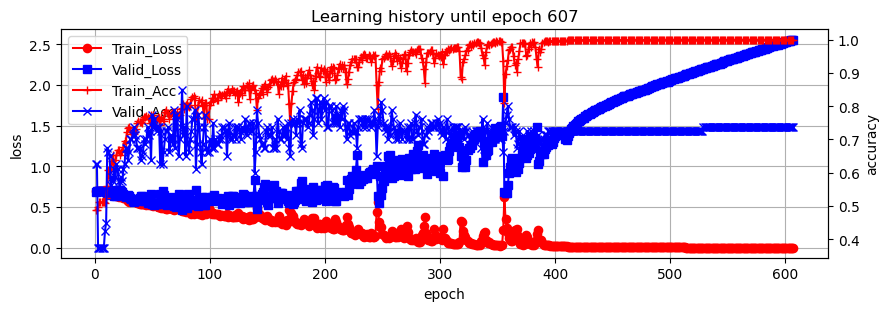

Epoch: 607 | T_Loss   0.0 | T_Acc   1.0 | V_Loss 2.559 | V_Acc 0.737 | 4.047
Epoch: 606 | T_Loss   0.0 | T_Acc   1.0 | V_Loss 2.553 | V_Acc 0.737 | 3.771
Epoch: 605 | T_Loss   0.0 | T_Acc   1.0 | V_Loss  2.55 | V_Acc 0.737 |  3.86
Epoch: 604 | T_Loss   0.0 | T_Acc   1.0 | V_Loss 2.549 | V_Acc 0.737 | 3.915
Epoch: 603 | T_Loss   0.0 | T_Acc   1.0 | V_Loss 2.544 | V_Acc 0.737 | 3.975
Epoch: 602 | T_Loss   0.0 | T_Acc   1.0 | V_Loss 2.539 | V_Acc 0.737 | 4.151
Epoch: 601 | T_Loss   0.0 | T_Acc   1.0 | V_Loss 2.536 | V_Acc 0.737 | 3.998
Epoch: 600 | T_Loss   0.0 | T_Acc   1.0 | V_Loss 2.531 | V_Acc 0.737 | 4.076
Epoch: 599 | T_Loss   0.0 | T_Acc   1.0 | V_Loss 2.525 | V_Acc 0.737 | 4.139
Epoch: 598 | T_Loss   0.0 | T_Acc   1.0 | V_Loss 2.521 | V_Acc 0.737 | 4.242
Epoch: 597 | T_Loss   0.0 | T_Acc   1.0 | V_Loss 2.517 | V_Acc 0.737 | 4.154
Epoch: 596 | T_Loss   0.0 | T_Acc   1.0 | V_Loss  2.51 | V_Acc 0.737 | 4.196
Epoch: 595 | T_Loss   0.0 | T_Acc   1.0 | V_Loss 2.503 | V_Acc 0.737 | 4.275

KeyboardInterrupt: 

In [41]:
# Training initialization
init_model()
init_epoch()
init_log()
maximum_epoch = EPOCH

# Training iteration

while epoch_not_finished():
    start_time = time.time()

    tloss, tacc = epoch(train_loader, mode = 'train')

    end_time = time.time()
    time_taken = end_time - start_time
    record_train_log(tloss, tacc, time_taken)

    with torch.no_grad():
        vloss, vacc = epoch(val_loader, mode = 'val')
        record_valid_log(vloss, vacc)

    print_log()

print('\n Training completed!')